# Q1

## Introduction and Research Motivation
This experiment evaluates the claim that  
**“ZIP traders generate more profit than ZIC traders in homogeneous and periodic BSE markets with static and symmetric demand and supply curves.”**

### Experimental Design
To test this claim, I use the BSE simulator to create a controlled market with the following properties:
- **Homogeneous:** Each session contains only one trader type (all ZIP or all ZIC), allowing a clean comparison of their profitability.
- **Static & Symmetric Schedules:** Demand and supply curves are fixed and centred around an equilibrium price, ensuring a stable competitive environment.
- **Periodic Order Flow:** Orders arrive at regular intervals, creating a periodic CDA market as required by the brief.

### Motivation
This setup isolates the effect of the trading algorithms:
- **ZIP** adapts its margins and tends to converge quickly toward the competitive equilibrium, which may compress spreads and reduce per-trade profit.
- **ZIC** generates random quotes, resulting in less efficient markets but potentially wider spreads on successful trades.
To evaluate the claim, I run multiple IID sessions for each trader type, collect the end-of-session average profit per trader, and apply a statistical hypothesis test to compare their mean profitability.


## Q1.1 Import the necessary packages

In [1]:
import BSE as bse
import glob
import csv
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import stats
from math import sqrt
from scipy.stats import t
from tqdm.notebook import tqdm


### Delete all.csv files to ensure the working directory is clean

In [10]:
patterns = [
    '*_avg_balance.csv',
    '*_tape.csv',
    '*_LOB_frames.csv',
    '*_blotter.csv',
    '*_strats.csv',
]

files_to_remove = []
for pat in patterns:
    files_to_remove.extend(glob.glob(pat))

for f in files_to_remove:
    os.remove(f)

print(f"Removed {len(files_to_remove)} old BSE log files.")


Removed 60 old BSE log files.


## Q1.2 Market environment construction

In [3]:
# Q1 experiment parameters setting area 
params = dict(
    eq=100,        
    width=40,      
    n_buyers=15,
    n_sellers=15,
    start_time=0,
    end_time=600,  
    interval=1,   # 每 interval 秒一批订单（periodic）
    n_runs=30      
)


eq        = params["eq"]
width     = params["width"]
n_buyers  = params["n_buyers"]
n_sellers = params["n_sellers"]
start_time = params["start_time"]
end_time   = params["end_time"]
interval   = params["interval"]
n_runs     = params["n_runs"]



In [4]:
def make_trader_spec(ttype, n_buyers, n_sellers):
    # "homogeneous" means that both the seller and the buyer are the same trader
    return {
        'buyers': [(ttype, n_buyers)],
        'sellers': [(ttype, n_sellers)],
        'mrktmakers': []
    }


def make_order_schedule(eq, width, start_time, end_time, interval): 

    half_spread = width / 2    
    # Symmetry
    dem_range = (eq, eq + half_spread)
    sup_range = (eq - half_spread, eq)
    
    supply_schedule = [{
        'from': start_time,
        'to': end_time,
        'ranges': [sup_range],
        'stepmode': 'fixed'
    }]

    demand_schedule = [{
        'from': start_time,
        'to': end_time,
        'ranges': [dem_range],
        'stepmode': 'fixed'
    }]

    order_sched = {
        'sup': supply_schedule,
        'dem': demand_schedule,
        'interval': interval,
        'timemode': 'periodic'  # Cyclical Market
    }
    return order_sched, start_time, end_time

In [5]:
def run_one_session(ttype, run_id,
                    eq, width,
                    n_buyers, n_sellers,
                    start_time, end_time,
                    interval):

    session_id = f"{ttype}_run{run_id:03d}"

    traders_spec = make_trader_spec(ttype, n_buyers, n_sellers)

    order_sched, st, et = make_order_schedule(eq=eq, width=width, 
                                              start_time=start_time,
                                              end_time=end_time,
                                              interval=interval)

    dump_flags = {
        'dump_blotters': False,
        'dump_lobs': False,
        'dump_strats': False,
        'dump_avgbals': True,   
        'dump_tape': False
    }

    verbose = False

    bse.market_session(session_id, st, et,
                       traders_spec, order_sched,
                       dump_flags, verbose)

    return session_id


def run_many_sessions(ttype, n_runs,
                      eq, width, 
                      n_buyers, n_sellers,
                      start_time, end_time, interval):
    """
    Run n_runs consecutively for sessions with the same configuration,
    with a progress bar.
    """
    for r in tqdm(range(n_runs),
                  desc=f"Running {ttype} sessions",
                  unit="run"):
        run_one_session(ttype, r + 1,
                        eq=eq, width=width, 
                        n_buyers=n_buyers, n_sellers=n_sellers,
                        start_time=start_time, end_time=end_time,
                        interval=interval)


## Q1.3 Running the Simulation Trials

In [6]:
print(f"Running {n_runs} sessions for ZIP...")
run_many_sessions('ZIP', n_runs, 
                  eq, width,n_buyers, n_sellers, 
                  start_time, end_time, interval)

print(f"Running {n_runs} sessions for ZIC...")
run_many_sessions('ZIC', n_runs, 
                  eq, width, n_buyers, n_sellers, 
                  start_time, end_time, interval)


print("Simulations complete. Files generated.")

Running 30 sessions for ZIP...


Running ZIP sessions:   0%|          | 0/30 [00:00<?, ?run/s]

Running 30 sessions for ZIC...


Running ZIC sessions:   0%|          | 0/30 [00:00<?, ?run/s]

Simulations complete. Files generated.


## Q1.4 Compute profit

In [7]:
def get_final_avg_profit_from_file(filename, ttype):
    with open(filename, 'r') as f:
        rows = list(csv.reader(f))
    last = rows[-1]        
    last = [x.strip() for x in last if x.strip() != '']

    i = 4
    while i < len(last):
        this_type = last[i]
        total_prof = float(last[i+1])
        n_traders = int(last[i+2])
        avg_prof = float(last[i+3])
        if this_type == ttype:
            return avg_prof
        i += 4

    raise ValueError("Type not found in file: " + filename)


def collect_profits(ttype):
    profits = []
    pattern = f"{ttype}_run*_avg_balance.csv"
    for fname in glob.glob(pattern):
        p = get_final_avg_profit_from_file(fname, ttype)
        profits.append(p)
    
    if len(profits) != n_runs:
        print(f"Warning: Expected {n_runs} results for {ttype}, but found {len(profits)}.")
        
    return np.array(profits)

zip_profits = collect_profits('ZIP')
zic_profits = collect_profits('ZIC')

print(f"ZIP sessions collected: {len(zip_profits)}")
print(f"ZIC sessions collected: {len(zic_profits)}")

ZIP sessions collected: 30
ZIC sessions collected: 30


## Q1.5 Statistical Hypothesis Test

To formally test the claim that ZIP profits ($\mu_{\text{ZIP}}$) are greater than ZIC profits ($\mu_{\text{ZIC}}$), a **Welch's Two-Sample Independent T-Test** is employed.

### Hypotheses and Test Setup

1.  **Test Type:** Welch's T-Test (assumes unequal variances, `equal_var=False`), suitable for comparing two independent sample means.
2.  **Null Hypothesis ($H_0$):** $\mu_{\text{ZIP}} \le \mu_{\text{ZIC}}$ (ZIP profit is not greater than ZIC profit).
3.  **Alternative Hypothesis ($H_1$):** $\mu_{\text{ZIP}} > \mu_{\text{ZIC}}$ (The original claim).
4.  **Decision Rule:** We use a **one-sided test** with a significance level $\alpha=0.05$. We reject $H_0$ if the one-sided $p$-value is less than $0.05$.

## Q1.6 Comparision of Average Profit per Trader

In [8]:

t_stat, p_value_two_sided = stats.ttest_ind(
    zip_profits, zic_profits,
    equal_var=False # Welch's T-Test
)

# H1: ZIP > ZIC
# if t > 0，then p value = two side p/2
if t_stat > 0:
    p_value_one_sided = p_value_two_sided / 2.0
else:
    # if t <= 0，then p value approximate to 1.0.
    p_value_one_sided = 1.0 - p_value_two_sided / 2.0

alpha = 0.05
zip_mean = zip_profits.mean()
zic_mean = zic_profits.mean()

print(f"--- Statistical Hypothesis Test Results (H1: ZIP > ZIC, α={alpha}) ---")
print(f"Mean ZIP Profit: {zip_mean:.4f}")
print(f"Mean ZIC Profit: {zic_mean:.4f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"One-sided P-value: {p_value_one_sided:.4f}")

# Conclusion
if p_value_one_sided < alpha:
    print(f"\nConclusion: Since P-value ({p_value_one_sided:.4f}) < alpha ({alpha}), we reject H0.")
    print("The claim that ZIP profits are significantly higher than ZIC profits IS supported by the data.")
else:
    print(f"\nConclusion: Since P-value ({p_value_one_sided:.4f}) >= alpha ({alpha}), we DO NOT reject H0.")
    print("There is insufficient evidence to support the claim that ZIP profits are significantly higher than ZIC profits.")

--- Statistical Hypothesis Test Results (H1: ZIP > ZIC, α=0.05) ---
Mean ZIP Profit: 124.8800
Mean ZIC Profit: 230.6389
T-statistic: -6.8008
One-sided P-value: 1.0000

Conclusion: Since P-value (1.0000) >= alpha (0.05), we DO NOT reject H0.
There is insufficient evidence to support the claim that ZIP profits are significantly higher than ZIC profits.


## Q1.6 Comparision of Average Profit per Trader (Plot)

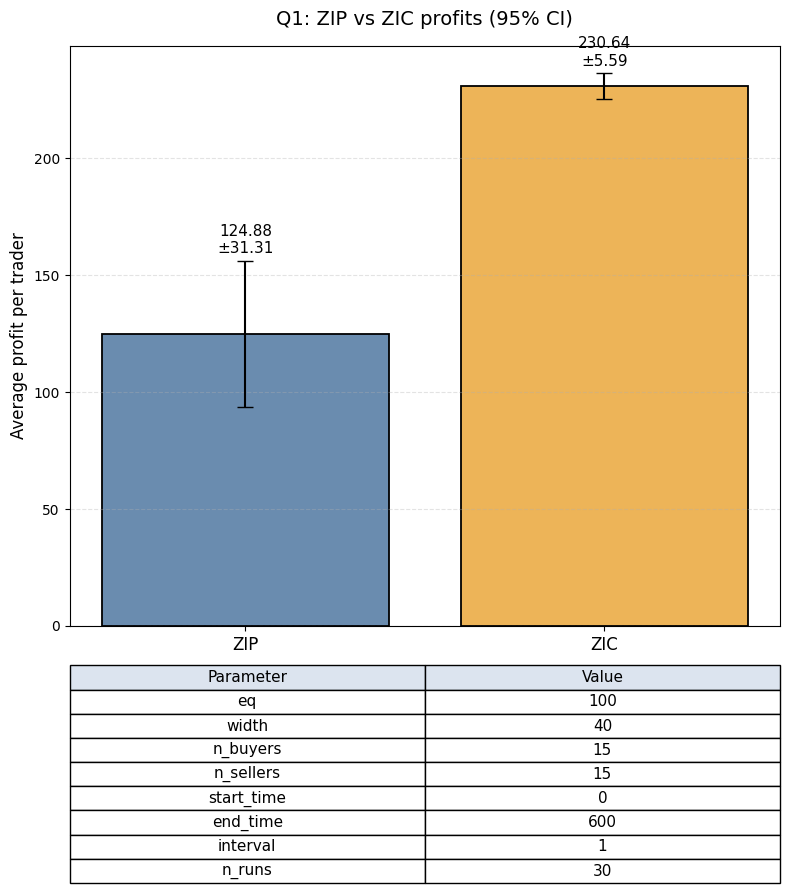

In [9]:
zip_mean = zip_profits.mean()
zic_mean = zic_profits.mean()
zip_std  = zip_profits.std(ddof=1)
zic_std  = zic_profits.std(ddof=1)
n_zip    = len(zip_profits)
n_zic    = len(zic_profits)

alpha = 0.05
df = min(n_zip, n_zic) - 1
t_crit = t.ppf(1 - alpha/2, df)

zip_ci = t_crit * zip_std / sqrt(n_zip)
zic_ci = t_crit * zic_std / sqrt(n_zic)

means = [zip_mean, zic_mean]
cis   = [zip_ci,  zic_ci]
labels = ['ZIP', 'ZIC']


colors = ['#6A8CAF', '#EDB458']    


param_items = [
    ('eq', eq),
    ('width', width),
    ('n_buyers', n_buyers),
    ('n_sellers', n_sellers),
    ('start_time', start_time),
    ('end_time', end_time),
    ('interval', interval),
    ('n_runs', n_runs),
]


fig = plt.figure(figsize=(8, 9))
grid = fig.add_gridspec(2, 1, height_ratios=[3.2, 1])


ax_bar = fig.add_subplot(grid[0])

x_pos = np.arange(len(labels))
bars = ax_bar.bar(x_pos, means, yerr=cis, capsize=6,
                  color=colors, edgecolor='black', linewidth=1.3)

ax_bar.set_xticks(x_pos)
ax_bar.set_xticklabels(labels, fontsize=12)
ax_bar.set_ylabel("Average profit per trader", fontsize=12)
ax_bar.set_title("Q1: ZIP vs ZIC profits (95% CI)", fontsize=14, pad=15)


for i, (m, ci) in enumerate(zip(means, cis)):
    ax_bar.text(i, m + ci + 2,
                f"{m:.2f}\n±{ci:.2f}",
                ha='center', va='bottom', fontsize=11)

ax_bar.grid(axis='y', linestyle='--', alpha=0.35)


ax_table = fig.add_subplot(grid[1])
ax_table.axis('off')

table_data = [[k, str(v)] for (k, v) in param_items]

table = ax_table.table(cellText=table_data,
                       colLabels=['Parameter', 'Value'],
                       loc='center',
                       cellLoc='center',
                       colColours=["#DCE4EF", "#DCE4EF"])  

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.2)

plt.tight_layout()
plt.show()